In [3]:
import numpy as np
import pandas as pd
from numpy.random import randn
from pandas import Series, DataFrame
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa.stattools as smtools
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.tsa.stattools import adfuller

In [4]:
df = pd.read_stata('homes.dta')

In [5]:
df.head()

,homes,irate
0,676,8.43
1,639,8.76
2,554,8.94
3,546,8.85
4,554,8.67


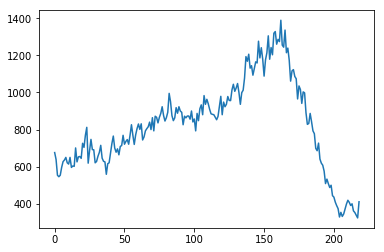

In [6]:
df['homes'].plot() 
plt.show()

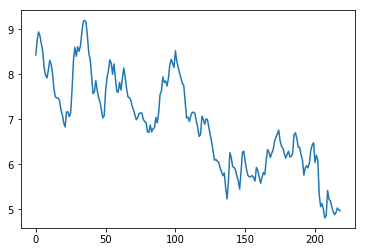

In [7]:
df['irate'].plot() 
plt.show()

In [8]:
#Create data index
ts = pd.period_range(start = '1.1.1992',end = '3.1.2010', freq='M')
df['Date'] = ts
df.set_index('Date',inplace=True)

In [9]:
result = adfuller(df['homes'],regression='ct', autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
# at even 1 % significance level we have not enough evidence to reject the non-stationarity hypothesis, so the data is not stationary.

ADF Statistic: -1.227023
p-value: 0.904818
Critical Values:
	1%: -4.003
	5%: -3.432
	10%: -3.140


In [10]:
df['dhomes'] = df['homes'].diff(periods=1)
df['dirate'] = df['irate'].diff(periods=1)
df.dropna(inplace=True)

In [11]:
df.parse_dates=[0]

C:\Users\Acer\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


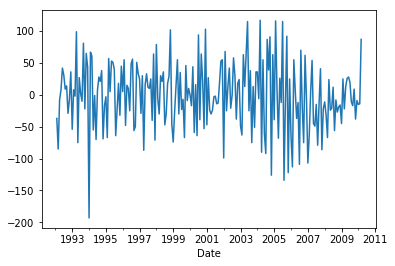

In [12]:
df['dhomes'].plot() 
plt.show()

In [13]:
result = adfuller(df['dhomes'],regression='ct', autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# here the p_value is almost 0 so the data is already stationary after the first differencing.

ADF Statistic: -7.425932
p-value: 0.000000
Critical Values:
	1%: -4.002
	5%: -3.431
	10%: -3.139


In [14]:
result = adfuller(df['dirate'],regression='ct', autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
# here the p_value is almost 0 so the data is already stationary after the first differencing.

ADF Statistic: -7.673954
p-value: 0.000000
Critical Values:
	1%: -4.002
	5%: -3.431
	10%: -3.139


In [15]:
#creating lagged variables
df['lag1_dhomes'] = df['dhomes'].shift(1)
df['lag1_dirate'] = df['dirate'].shift(1)
df['lag2_dirate'] = df['dirate'].shift(2)
df.dropna(inplace=True)

In [16]:
df.head()

,homes,irate,dhomes,dirate,lag1_dhomes,lag1_dirate,lag2_dirate
Date,,,,,,,
1992-04,546,8.85,-8.0,-0.09,-85.0,0.18,0.33
1992-05,554,8.67,8.0,-0.18,-8.0,-0.09,0.18
1992-06,596,8.51,42.0,-0.16,8.0,-0.18,-0.09
1992-07,627,8.13,31.0,-0.38,42.0,-0.16,-0.18
1992-08,636,7.98,9.0,-0.15,31.0,-0.38,-0.16


In [17]:
# Prepare target and input variables. 
X_multi=df.drop(['homes','irate','dhomes','dirate'], axis=1)
Y_target=df.dhomes

In [18]:
# Add the costant to our input variables
X_multi=sm.tools.tools.add_constant(X_multi, prepend=True, has_constant='skip')

In [19]:
# OLS Regression
mod = sm.OLS(Y_target, X_multi)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 dhomes   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     12.40
Date:                Tue, 05 Mar 2019   Prob (F-statistic):           1.67e-07
Time:                        12:54:54   Log-Likelihood:                -1143.7
No. Observations:                 216   AIC:                             2295.
Df Residuals:                     212   BIC:                             2309.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.4912      3.333     -0.748      

In [20]:
#  const and lag_2_dirate are not significant, all the are others are significantly different from 0.

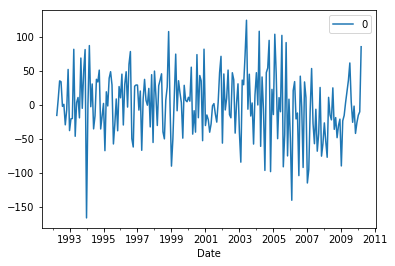

                0
count  216.000000
mean     0.000000
std     48.340305
min   -166.073456
25%    -29.618060
50%     -0.176863
75%     34.270468
max    124.572979


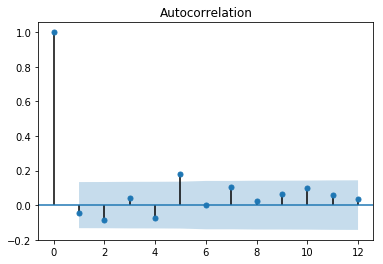

In [21]:
residuals = DataFrame(res.resid)
residuals.plot()
plt.show()
print(residuals.describe())
plot_acf(residuals,lags=12)
plt.show()
# the plot shows that there is significant serial correlation at lag 5

In [22]:
acorr_breusch_godfrey(res, nlags=2)
#p_val>0.05 , so at 5 % significance level we do not have enough evidence to reject H0 
#and we state that there is no autocorellation between errors.

(4.8535861368711055,
 0.0883196138673761,
 2.4136168597294683,
 0.09196988616432127)

In [23]:
#ARDl (5,3)
# creating the according lags 
df['lag5_dhomes'] = df["dhomes"].shift(5)
df['lag3_dirate'] = df['dirate'].shift(3)

In [24]:
df.dropna(inplace=True)

In [25]:
df.head()

,homes,irate,dhomes,dirate,lag1_dhomes,lag1_dirate,lag2_dirate,lag5_dhomes,lag3_dirate
Date,,,,,,,,,
1992-09,650,7.92,14.0,-0.06,9.0,-0.15,-0.38,-8.0,-0.16
1992-10,621,8.09,-29.0,0.17,14.0,-0.06,-0.15,8.0,-0.38
1992-11,614,8.31,-7.0,0.22,-29.0,0.17,-0.06,42.0,-0.15
1992-12,650,8.22,36.0,-0.09,-7.0,0.22,0.17,31.0,-0.06
1993-01,596,8.02,-54.0,-0.20,36.0,-0.09,0.22,9.0,0.17


In [26]:
X=df[["lag1_dhomes","lag1_dirate","lag5_dhomes","lag3_dirate",]]
Y=df.dhomes

In [27]:
X=sm.tools.tools.add_constant(X, prepend=True, has_constant='skip')

In [28]:
#OLS
model = sm.OLS(Y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 dhomes   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     13.19
Date:                Tue, 05 Mar 2019   Prob (F-statistic):           1.38e-09
Time:                        12:54:55   Log-Likelihood:                -1112.1
No. Observations:                 211   AIC:                             2234.
Df Residuals:                     206   BIC:                             2251.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.1238      3.306     -0.945      

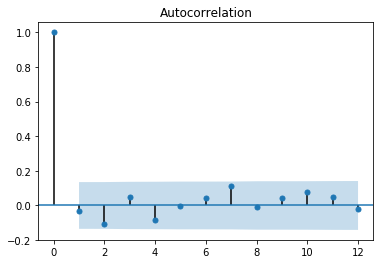

In [29]:
# we can also check is there is serial correlation or not now
residuals=result.resid
plot_acf(residuals,lags=12)
plt.show()
# so we see the little autocorrelation that exicted then now is not present any more, so in this part also the model is imporved.

I think this model is better as
-all variables except constant are significant 

-Adjusted R square is a little higher

-Aic is a little lower

-no autocorrelation

-std imporved



# 9.20

In [56]:
df['lag2_homes'] = df["homes"].shift(2)
df['lag1_homes'] = df['homes'].shift(1)
df.dropna(inplace=True)
X=df[["lag1_homes","lag2_homes","lag1_dirate","lag5_dhomes","lag3_dirate"]]
X=sm.tools.tools.add_constant(X, prepend=True, has_constant='skip')
Y=df.homes

In [57]:
#OLS new for the transformed model, 
#I understand that it can be slightly different from the previous model 
#as I run a new OlS instead of doing that by hand by just changing the variables and keeping the old parameters 
model_new = sm.OLS(Y, X)
result_new = model_new.fit()
print(result_new.summary())

                            OLS Regression Results                            
Dep. Variable:                  homes   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     998.7
Date:                Tue, 05 Mar 2019   Prob (F-statistic):          8.04e-138
Time:                        13:12:05   Log-Likelihood:                -1071.1
No. Observations:                 203   AIC:                             2154.
Df Residuals:                     197   BIC:                             2174.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.8409     12.550     -0.067      

                  0
count  2.090000e+02
mean  -3.050343e-11
std    4.730674e+01
min   -1.785061e+02
25%   -3.299020e+01
50%    2.016879e+00
75%    3.097113e+01
max    1.241863e+02


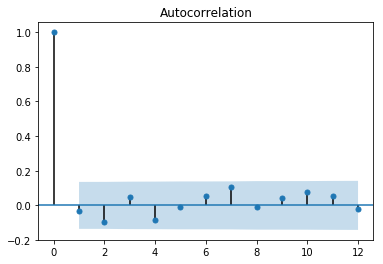

In [32]:
residuals = DataFrame(result_new.resid)
print(residuals.describe())
plot_acf(residuals,lags=12)
plt.show()

In [46]:
df[["homes","dhomes","irate","dirate"]].tail(10)

,homes,dhomes,irate,dirate
Date,,,,
2009-06,399,28.0,5.42,0.56
2009-07,419,20.0,5.22,-0.20
2009-08,408,-11.0,5.19,-0.03
2009-09,391,-17.0,5.06,-0.13
2009-10,400,9.0,4.95,-0.11
2009-11,362,-38.0,4.88,-0.07
2009-12,353,-9.0,4.93,0.05
2010-01,338,-15.0,5.03,0.10
2010-02,324,-14.0,4.99,-0.04


In [51]:
April=[1,-0.02,-38,0.1,411,324]
april=np.asarray(April)
Y_april=result_new.predict(april)

May=[1,0,-9,-0.04,Y_april,411]
may=np.asarray(May)
Y_May=result_new.predict(may)

June=[1,0,-15,-0.02,Y_May,Y_april]
june=np.asarray(June)
Y_June=result_new.predict(june)
print("April:", Y_april)
print("May:", Y_May)
print("June:", Y_June)

April: [371.82342681]
May: [382.7260674]
June: [376.0942916]


In [70]:
# to find the interval we should use the following formula 
# forecast +- t(0.95)x standard error

std1=47.5
std2=std1*np.sqrt(1+result_new.params["lag1_homes"]**2)
std3=std1*np.sqrt((result_new.params["lag1_homes"]**2+result_new.params["lag2_homes"])**2+result_new.params["lag1_homes"]**2+1)
#from the residuals description
t_95=1.97
# so the confidence interval for april will be
UL_A=Y_april+t_95*std1
LL_A=Y_april-t_95*std1
UL_M=Y_May+t_95*std2
LL_M=Y_May-t_95*std2
UL_J=Y_June+t_95*std2
LL_J=Y_June-t_95*std2
print("April: ",LL_A,UL_A)
print("May: ",LL_M,UL_M)
print("June: ",LL_J,UL_J)


April:  [278.24842681] [465.39842681]
May:  [268.90385393] [496.54828088]
June:  [262.27207813] [489.91650508]
